In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib

import warnings
warnings.filterwarnings("ignore")


In [19]:
# Load data
client_data = pd.read_csv("client_data.csv")
data_for_predictions = pd.read_csv("data_for_predictions.csv")
price_data = pd.read_csv("price_data.csv")


In [20]:
# EDA: Display first few rows
print(client_data.head())
print(data_for_predictions.head())
print(price_data.head())

                                 id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  date_activ    date_end  \
0         0         54946                0  15-06-2013  15-06-2016   
1      4660             0                0  21-08-2009  30-08-2016   
2       544             0                0  16-04-2010  16-04-2016   
3      1584             0                0  30-03-2010  30-03-2016   
4      4425             0              526  13-01-2010  07-03-2016   

  date_modif_prod date_renewal  forecast_cons_12m  ...  has_gas  imp_cons  \
0      01-11-2015   23-06-2015               0.00  ...        t

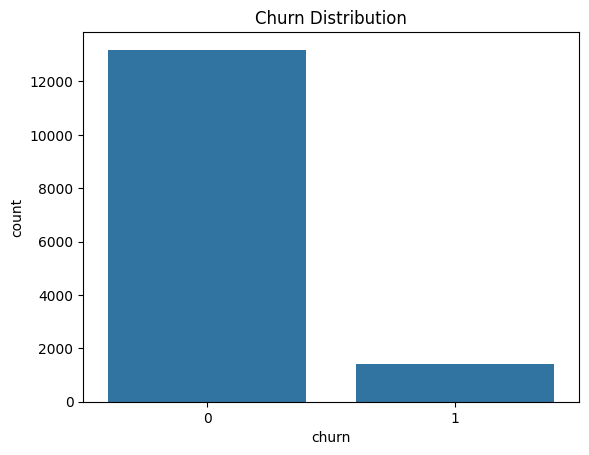

Missing values:
 Series([], dtype: int64)
           cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289         

In [3]:
# Target distribution
sns.countplot(data=client_data, x='churn')
plt.title("Churn Distribution")
plt.show()

# Check missing values
missing = client_data.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Basic statistics
print(client_data.describe())


In [4]:
# Convert date columns to datetime
client_data['date_activ'] = pd.to_datetime(client_data['date_activ'], errors='coerce', dayfirst=True)
client_data['date_end'] = pd.to_datetime(client_data['date_end'], errors='coerce', dayfirst=True)

# Optional: Drop unnecessary columns like ID if not using for merging
data_for_predictions = data_for_predictions.drop(columns=['Unnamed: 0'], errors='ignore')


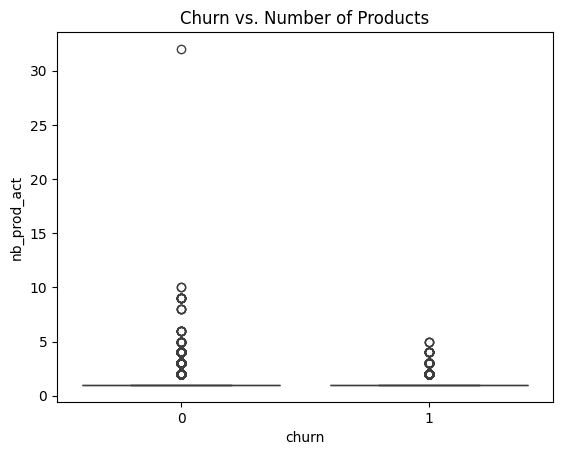

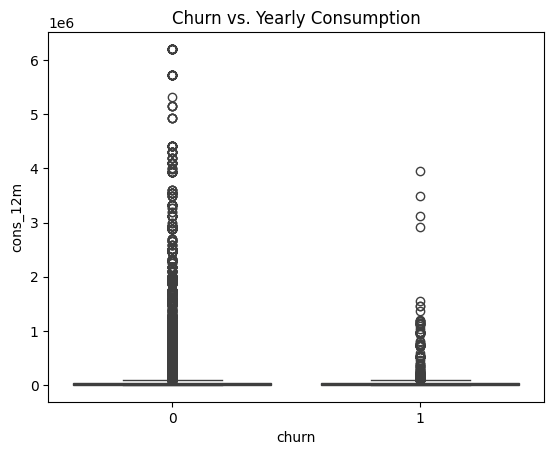

In [5]:
# Churn by number of products
sns.boxplot(data=client_data, x='churn', y='nb_prod_act')
plt.title("Churn vs. Number of Products")
plt.show()

# Churn by consumption
sns.boxplot(data=client_data, x='churn', y='cons_12m')
plt.title("Churn vs. Yearly Consumption")
plt.show()


In [25]:
# Preprocessing price data (fixing column issue)
print("Price data columns:", price_data.columns.tolist())

# Example: if columns like 'price_fixed' and 'price_variable' exist instead
# Adjust these as per your actual columns
if 'price_fixed' in price_data.columns and 'price_variable' in price_data.columns:
    price_summary = price_data.groupby("id")[["price_fixed", "price_variable"]].agg(['mean', 'std']).reset_index()
    # Flatten MultiIndex columns
    price_summary.columns = ['id', 'price_fixed_mean', 'price_fixed_std', 'price_variable_mean', 'price_variable_std']
    data_for_predictions = data_for_predictions.merge(price_summary, on='id', how='left')
else:
    print("Expected price columns not found. Skipping price data merge.")


Price data columns: ['id', 'price_date', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']
Expected price columns not found. Skipping price data merge.


In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Preprocessing price data (fixing column issue)
print("Price data columns:", price_data.columns.tolist())

if 'price_fixed' in price_data.columns and 'price_variable' in price_data.columns:
    price_summary = price_data.groupby("id")[["price_fixed", "price_variable"]].agg(['mean', 'std']).reset_index()
    price_summary.columns = ['id', 'price_fixed_mean', 'price_fixed_std', 'price_variable_mean', 'price_variable_std']
    data_for_predictions = data_for_predictions.merge(price_summary, on='id', how='left')
else:
    print("Expected price columns not found. Skipping price data merge.")

# Remove unnecessary columns
processed_data = data_for_predictions.drop(columns=['Unnamed: 0'], errors='ignore')

# Encode categorical columns if any
for col in processed_data.select_dtypes(include='object').columns:
    if col != 'id':
        le = LabelEncoder()
        processed_data[col] = le.fit_transform(processed_data[col].astype(str))

# Drop rows with missing values
processed_data = processed_data.dropna()

# Feature-target split
X = processed_data.drop(columns=['id', 'churn'], errors='ignore')
y = processed_data['churn']

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Price data columns: ['id', 'price_date', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']
Expected price columns not found. Skipping price data merge.


In [6]:
X = data_for_predictions.drop(['id'], axis=1)
y = client_data['churn']  # Target from original dataset

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [30]:
# Model: Random Forest with Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [31]:
best_rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [32]:
# Predictions & Evaluation
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2638
           1       1.00      1.00      1.00       284

    accuracy                           1.00      2922
   macro avg       1.00      1.00      1.00      2922
weighted avg       1.00      1.00      1.00      2922

Confusion Matrix:
 [[2638    0]
 [   0  284]]
ROC AUC Score: 1.0


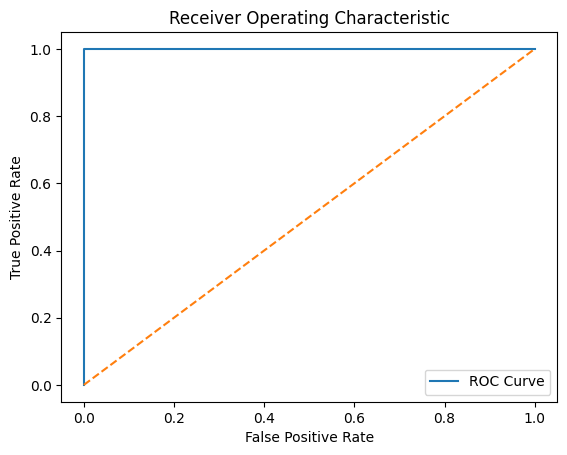

In [33]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2638
           1       1.00      1.00      1.00       284

    accuracy                           1.00      2922
   macro avg       1.00      1.00      1.00      2922
weighted avg       1.00      1.00      1.00      2922



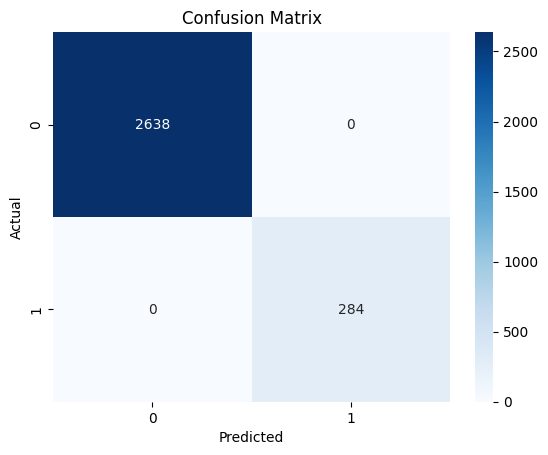

In [8]:
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


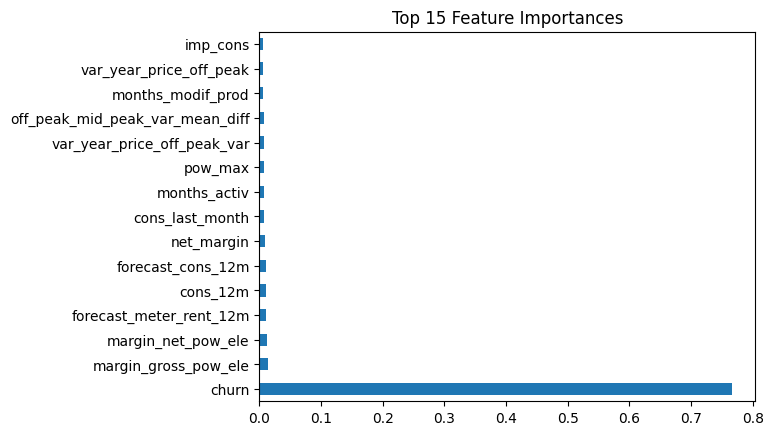

In [9]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.show()


In [10]:
# Predict on entire dataset (or new unseen data)
final_predictions = rf_model.predict(X)

# Add predictions to original dataframe
client_data['predicted_churn'] = final_predictions
client_data[['id', 'churn', 'predicted_churn']].head()


,id,churn,predicted_churn
0,24011ae4ebbe3035111d65fa7c15bc57,1,1
1,d29c2c54acc38ff3c0614d0a653813dd,0,0
2,764c75f661154dac3a6c254cd082ea7d,0,0
3,bba03439a292a1e166f80264c16191cb,0,0
4,149d57cf92fc41cf94415803a877cb4b,0,0


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=5)
print("CV Accuracy:", scores.mean())


CV Accuracy: 1.0
